# <center>Phase 2 - Publication<center>

In [90]:
# General imports.
import sqlite3
import pandas as pd
from matplotlib_venn import venn2, venn3
import scipy.stats as scs
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from  itertools import combinations
import os
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from scipy.stats import ttest_ind

# Imports from neighbor directories.
import sys
sys.path.append("..")
from src.features import field_registry as fieldreg

# IPython magics for this notebook.
%matplotlib inline

# Use latex font for matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [91]:
# Data Globals
FR = fieldreg.FieldRegistry()
TOTAL_USERS = 0
REMAINING_USERS = 0
TOTAL_DOGS = 0
REMAINING_DOGS = 0
PREVALENCE = lambda x: (x / REMAINING_DOGS) * 100
CATEGORY_MATRIX = pd.DataFrame()

# Database Globals
USER_TABLE = 'users'
DOG_TABLE = 'dogs'
BIAS_FILTER = '''
    USING (record_id)
    WHERE question_reason_for_part_3 = 0
    OR (question_reason_for_part_3 = 1 AND q01_main != 1)'''
CON = sqlite3.connect('../data/processed/processed.db')

In [92]:
def createStringDataFrame(table, fields, labels, filtered=True):
    query = 'SELECT ' + fields + ' FROM ' + table
    if filtered:
        table2 = USER_TABLE if table == DOG_TABLE else DOG_TABLE
        query += ' JOIN ' + table2 + ' ' + BIAS_FILTER
    df = pd.read_sql_query(query, CON)
    df.columns = labels
    return df

def convertToNumeric(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def createNumericDataFrame(table, fields, labels, filtered=True):
    df = createStringDataFrame(table, fields, labels, filtered)
    return convertToNumeric(df)

def replaceFields(df, column, replacement_dict):
    df[column].replace(replacement_dict, inplace=True)

def getValueCountAndPrevalence(df, field):
    s = df[field].value_counts()
    p = s.apply(PREVALENCE)
    rv = pd.concat([s, p], axis=1)
    rv.columns = ['frequency', 'prevalence']
    return rv
        
def exportTable(data, title):
    file_ = os.path.join('..', 'reports', 'tables', title) + '.tex'
    with open(file_, 'w') as tf:
        tf.write(r'\documentclass[varwidth=\maxdimen]{standalone}\usepackage{booktabs}\begin{document}')
        tf.write(df.to_latex())
        tf.write(r'\end{document}')
        
def exportFigure(figure, title):
    file_ = os.path.join('..', 'reports', 'figures', title) + '.png'
    figure.tight_layout()
    figure.savefig(file_, dpi = 500)

def createCategoryMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createQuestionMatrix():
    fields = ''
    for cat, sublist in FR.fields.items():
        for field in sublist:
            fields += '{}, '.format(field)
    fields = fields[:-2]
    labels = []
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            labels.append(key)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createCorrelationMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    return df.corr()

def createOddsRatioMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = getOddsRatio(contingency)
        pvalue[pair[1]][pair[0]] = getOddsRatio(contingency)
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def displayOddsRatio(df):
    odds = getOddsRatio(df)
    print("odds ratio = %f" %odds)  

def getOddsRatio(df):
    return (df[1][1]/df[1][0])/(df[0][1]/df[0][0])

def get_significance_category(p):
    if np.isnan(p):
        return p
    elif p > 10**(-3):
        return -1
    elif p <= 10**(-3) and p > 10**(-6):
        return 0
    else:
        return 1 

## <center>Demographics</center>

### Number of participants:

In [93]:
df = createNumericDataFrame(USER_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_USERS = df['count'][0]
print('N = %d owners [unadjusted]' %TOTAL_USERS)

N = 3201 owners [unadjusted]


### Number of participating dogs:

In [94]:
df = createNumericDataFrame(DOG_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_DOGS = df['count'][0]
print('N = %d dogs [unadjusted]' %TOTAL_DOGS)

N = 5018 dogs [unadjusted]


### Motivation for enrollment:

In [95]:
# Create the necessary dataframe.
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['Love for dogs', 'You help shelter animals', 'Suspicion of behavior problems',
          'Work with animals', 'Other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
s = df.sum(0, skipna=False)
s = s.sort_values(ascending=False)
df = pd.DataFrame(index=s.index, data={'Count':s.values})
df.columns.name = 'Motivation'
display(df)
# NOTE: This does not include a count of users who did not provide a reason.

Motivation,Count
Love for dogs,2595
You help shelter animals,1377
Work with animals,1049
Suspicion of behavior problems,830
Other,273


### Suspicion of behavior problems as one of multiple motivating factors:

In [96]:
# Create the necessary dataframe.
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
s = df.sum(0, skipna=False)

print('n = %d owners (%d%%) [unadjusted]' %(s.iloc[2], (s.iloc[2]/TOTAL_USERS * 100)))

n = 830 owners (25%) [unadjusted]


### Suspicion of behavior problems as the sole motivating factor:

In [97]:
# Create the necessary dataframe.
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
df = df[df['sum'] == 1]
s = df.sum(0, skipna=False)

print('n = %d owners (%d%%) [unadjusted]' %(s.iloc[2], (s.iloc[2]/TOTAL_USERS * 100)))

n = 98 owners (3%) [unadjusted]


### Adjusting sample for bias:

In [98]:
fields = 'q02_score'
labels = ['Score']
df_gross = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=False)
cnt_total_dogs_w_problems = len(df_gross[df_gross[labels[0]] != 0].index)

df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
REMAINING_DOGS = len(df_adjusted_dogs.index)
cnt_total_dogs_w_problems_adjusted = len(
    df_adjusted_dogs[df_adjusted_dogs[labels[0]] != 0].index)

df_adjusted_users = createNumericDataFrame(USER_TABLE, 'COUNT(DISTINCT email)', ['count'])
REMAINING_USERS = df_adjusted_users['count'][0]


# Display the count results.
print('\nAdjusted study population:')
print('N = %d owners (adjusted)' %REMAINING_USERS)
print('N = %d dogs (adjusted)' %REMAINING_DOGS)


Adjusted study population:
N = 2480 owners (adjusted)
N = 4114 dogs (adjusted)


### Dogs per household:

In [99]:
fields = 'record_id'
labels = ['record index']
df = createStringDataFrame(DOG_TABLE, fields, labels)

record_dict = {}
for index, row in df.iterrows():
    key = row.iloc[0]
    if not key in record_dict:
        record_dict[key] = 1
    else:
        record_dict[key] += 1

s = pd.Series(record_dict, name='dogs')
df = pd.DataFrame(index=s.index, data={'dogs':s.values})
display(df.describe().round(2))

,dogs
count,2480.00
mean,1.66
std,0.96
min,1.00
25%,1.00
50%,1.00
75%,2.00
max,13.00


### Age at date of response

In [100]:
fields = 'dog_age_today_months'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

,age (months)
count,4030.000000
mean,79.747270
std,47.424445
min,2.000000
25%,36.000000
50%,72.000000
75%,120.000000
max,252.000000


### Age at neutering:

In [101]:
fields = 'dog_sex_month'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

,age (months)
count,2771.000000
mean,19.015698
std,23.823208
min,2.000000
25%,6.000000
50%,9.000000
75%,24.000000
max,180.000000


### Number of dogs per source of origin:

In [102]:
# Construct the dataframe.
fields = 'acquisition_source'
labels = ['origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

origin,frequency
rescue,1787
breeder,1350
friends/family,343
other,224
self-bred,136
found,115
online (non-rescue),77
pet store,51
no response,31


### Age at onset:

In [103]:
fields = 'q01_age_months'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

fields = 'q01_acq'
labels = ['evident when acquired']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
cnt_evident_when_acquired = len(df[df[labels[0]] == 1].index)
print('Number of users who reported that the behavior problem was evident when acquired: %d'
      %(cnt_evident_when_acquired))

,age (months)
count,650.000000
mean,25.129385
std,29.085864
min,1.000000
25%,6.000000
50%,12.000000
75%,36.000000
max,180.000000


Number of users who reported that the behavior problem was evident when acquired: 591


### Gender:

In [104]:
# Construct the dataframe.
fields = 'dog_sex'
labels = ['gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'':'no response', '1':'male', '2':'female'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

gender,frequency
female,2095
male,2005
no response,14


### Neutered status:

In [105]:
# status: unverified
# Construct the dataframe.
fields = 'dog_sex, dog_spayed'
labels = ['Gender', 'Neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'':'No response', '1':'Male', '2':'Female'}
replaceFields(df, labels[0], replacements)
replacements = {'':'No response', '0':'No', '1':'Yes', '2':"I don't know"}
replaceFields(df, labels[1], replacements)
display(pd.crosstab(df[labels[0]], df[labels[1]], margins=True))

Neutered,I don't know,No,No response,Yes,All
Gender,,,,,
Female,3,308,6,1778,2095
Male,1,312,10,1682,2005
No response,0,0,2,12,14
All,4,620,18,3472,4114


### Number of purebred dogs:

In [106]:
# status: verified
fields = 'purebred'
labels = ['purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df.head()
replacements = {'':'No response', '0':'No', '1':'Yes'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

purebred,frequency
Yes,2335
No,1723
No response,56


### Number of purebred dogs without a breed designated:

In [107]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] == '']
purebred_missing_breed = df.describe().iloc[0][0]
print('Number of purebreds without breed designated: %d dogs' %(purebred_missing_breed))

Number of purebreds without breed designated: 197 dogs


### Number of purebred breeds:

In [108]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] != '']
display(df.describe())

,breed
count,2138
unique,142
top,labrador retriever
freq,382


### Numbers of dogs per purebred breed:

In [109]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] != '']

# Calculate sums and prevalences.
df = getValueCountAndPrevalence(df, labels[0])
df = df.round(2)
df.columns.name = labels[0]
display(df[:30])

breed,frequency,prevalence
labrador retriever,382,9.29
golden retriever,138,3.35
german shepherd dog,132,3.21
poodle,104,2.53
border collie,89,2.16
cocker spaniel,71,1.73
australian shepherd,58,1.41
dachshund,43,1.05
shetland sheepdog,36,0.88
chihuahua,33,0.80


## <center>Prevalence of Behavior Problems</center>

In [110]:
print('Dogs with behavior problems: n = %d (%d%%)'
      %(cnt_total_dogs_w_problems_adjusted,
       (cnt_total_dogs_w_problems_adjusted/REMAINING_DOGS * 100)))

Dogs with behavior problems: n = 3512 (85%)


### Prevalence of overall behavior problems:

In [111]:
# Calculate the gross prevalence.
prevalence_gross = (cnt_total_dogs_w_problems / TOTAL_DOGS) * 100

# Calculate the adjusted prevalence.
prevalence_adjusted = PREVALENCE(cnt_total_dogs_w_problems_adjusted)

# Calculate the difference between the gross and adjusted prevalence.
diff_prevalence = prevalence_adjusted - prevalence_gross
sign = '+' if diff_prevalence > 0 else ''

# Display the prevalence results.
print('Pre-adjustment prevalence: %.2f%% (%d/%d dogs)'
      %(prevalence_gross, cnt_total_dogs_w_problems, TOTAL_DOGS))
print('Post-adjustment prevalence: %.2f%% (%d/%d dogs)'
      %(prevalence_adjusted, cnt_total_dogs_w_problems_adjusted, REMAINING_DOGS))
print('Shift in prevalence as a result of adjustment: %s%.2f%%'
      %(sign, diff_prevalence))

Pre-adjustment prevalence: 87.82% (4407/5018 dogs)
Post-adjustment prevalence: 85.37% (3512/4114 dogs)
Shift in prevalence as a result of adjustment: -2.46%


### Prevalence of behavior problem categories (Table 1)

In [112]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, category in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(category)
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
total_dogs = len(df.index)
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Count':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Category'
display(df)
exportTable(df, 'table_1')

Category,Count,Prevalence (%)
Fear/Anxiety,1814,44.09
Aggression,1239,30.12
Jumping,1159,28.17
Excessive Barking,758,18.42
Coprophagia,718,17.45
Compulsion,639,15.53
House Soiling,614,14.92
Rolling in Repulsive Material,515,12.52
Overactivity/Hyperactivity,505,12.28
Destructive Behavior,489,11.89


### Prevalence of behavior problem category subtypes (Table 2)

In [113]:
# Create the necessary dataframe.
sums = pd.Series()
for i in range(0, 12):
    all_fields = FR.fields[FR.categories[i]].copy()
    all_labels = list(FR.labels[FR.categories[i]].values()).copy()
    df = createNumericDataFrame(DOG_TABLE, ', '.join(all_fields), all_labels, filtered=True)
    if sums.empty:
        sums = df.sum().sort_values(ascending=False)
    else:
        sums = sums.append(df.sum().sort_values(ascending=False))

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_2') # exporting will overwrite custom format

Behavior problem,Frequency,Prevalence (%)
Unfamiliar dogs on walks (on lead),674.0,16.38
Another dog in the home,447.0,10.87
Stangers visiting the home,391.0,9.50
Unfamiliar dogs on walks (off lead),371.0,9.02
Unfamiliar dogs visiting the home,371.0,9.02
Stangers away from the home,325.0,7.90
Familiar people in the home,296.0,7.19
Animals other than dogs in the home,172.0,4.18
Veterinarians,159.0,3.86
Groomers,55.0,1.34


In [114]:
### Prevalence ranked by age of onset:

In [115]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.append('q01_age_months')
labels.append('Age')
fields.append('q01_acq')
labels.append('Evident at Acquisition')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
#df = df[np.isfinite(df[labels[12]])]

# Ranges: 0=0-3m, 1=3-6m, 2=6m-1y, 3=1-3y, 4=3y+, 5=evident at acquisition
rngs = []
rngs.append(df[(df['Age'] < 3)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 3) & (df['Age'] < 6)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 6) & (df['Age'] < 12)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 12) & (df['Age'] < 36)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 36)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Evident at Acquisition'] == 1)].drop(columns=['Age', 'Evident at Acquisition']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))
prevs.append(get_group_prevalence(rngs[2]))
prevs.append(get_group_prevalence(rngs[3]))
prevs.append(get_group_prevalence(rngs[4]))
prevs.append(get_group_prevalence(rngs[5]))

df = pd.DataFrame(index=prevs[0].index, data={'0-3m': prevs[0], '3-6m': prevs[1], '6-12m': prevs[2],
                                              '12-36m': prevs[3], '+36m': prevs[4],
                                              'Evident at Acquisition': prevs[5]})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_4') # Exporting will overwrite custom formatting

Behavior problem,0-3m,3-6m,6-12m,12-36m,+36m,Evident at Acquisition
Aggression,45.45,45.28,51.04,60.82,54.71,39.42
Fear/Anxiety,45.45,53.77,51.04,53.22,51.18,67.85
Compulsion,27.27,15.09,18.75,20.47,20.59,20.47
House Soiling,54.55,12.26,14.58,11.11,18.24,27.58
Excessive Barking,9.09,22.64,32.29,26.32,24.12,22.67
Jumping,27.27,37.74,42.19,24.56,17.06,28.76
Mounting/Humping,18.18,16.98,14.58,12.28,4.12,10.15
Coprophagia,27.27,17.92,21.88,18.13,14.71,17.43
Destructive Behavior,27.27,16.98,16.67,15.20,15.88,17.43
Rolling in Repulsive Material,9.09,11.32,16.15,11.70,15.29,9.14


In [116]:
### Prevalence by gender and neutered status:

In [117]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.extend(('dog_sex', 'dog_spayed'))
labels.extend(('Gender', 'Neutered'))
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

df_intact_male = df[(df['Gender'] == 1) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_male = df[(df['Gender'] == 1) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])
df_intact_female = df[(df['Gender'] == 2) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_female = df[(df['Gender'] == 2) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

intact_male_p = get_group_prevalence(df_intact_male)
neutered_male_p = get_group_prevalence(df_neutered_male)
intact_female_p = get_group_prevalence(df_intact_female)
neutered_female_p = get_group_prevalence(df_neutered_female)

df = pd.DataFrame(index=intact_male_p.index, data={'Intact males': intact_male_p,
                                                   'Castrated males': neutered_male_p,
                                                   'Intact females': intact_female_p,
                                                   'Spayed females': neutered_female_p})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_3') # Exporting will overwrite custom formatting

Behavior problem,Intact males,Castrated males,Intact females,Spayed females
Aggression,19.55,35.61,16.23,29.08
Fear/Anxiety,29.49,45.78,29.87,47.53
Compulsion,10.90,17.30,7.47,16.09
House Soiling,11.22,15.52,9.74,16.03
Excessive Barking,10.26,20.33,11.69,19.35
Jumping,33.33,27.29,32.47,27.39
Mounting/Humping,17.31,13.26,6.82,7.48
Coprophagia,10.58,17.84,13.31,19.18
Destructive Behavior,11.86,11.89,11.69,11.92
Rolling in Repulsive Material,5.13,11.47,10.39,15.13


In [118]:
### Prevalence by origin:

In [119]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.append('acquisition_source')
labels.append('origin')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}

rngs = []
for i in range(1, 9):
    cnt = i
    if i >= 4:
        cnt += 1
    rngs.append(df[(df['origin'] == cnt)].drop(columns=['origin']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
for j in range(0, 8):
    prevs.append(get_group_prevalence(rngs[j]))

df = pd.DataFrame(index=intact_male_p.index, data={'Rescue': prevs[0], 'Online': prevs[1],
                                                   'Pet store': prevs[2], 'Breeder': prevs[3],
                                                   'Self-bred': prevs[4], 'Family/Friends': prevs[5],
                                                   'Found': prevs[6], 'Other': prevs[7]})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_5') # Exporting will overwrite custom formatting

Behavior problem,Rescue,Online,Pet store,Breeder,Self-bred,Family/Friends,Found,Other
Aggression,36.32,35.06,33.33,21.70,19.85,34.69,32.17,28.57
Fear/Anxiety,54.06,40.26,37.25,33.78,20.59,44.61,52.17,39.73
Compulsion,17.80,19.48,33.33,12.30,3.68,16.91,18.26,14.73
House Soiling,18.86,19.48,29.41,9.48,2.94,13.99,18.26,19.64
Excessive Barking,20.09,24.68,29.41,16.15,6.62,21.87,21.74,15.18
Jumping,28.15,40.26,33.33,28.59,19.85,28.86,25.22,26.79
Mounting/Humping,10.41,15.58,15.69,10.59,3.68,9.62,15.65,11.61
Coprophagia,19.81,15.58,23.53,16.44,13.24,15.74,10.43,14.73
Destructive Behavior,14.83,16.88,11.76,7.78,5.88,13.99,9.57,12.95
Rolling in Repulsive Material,13.04,22.08,11.76,11.70,6.62,11.37,12.17,15.62


In [120]:
### Prevalence by purebred lineage:

In [121]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)
fields.append('purebred')
labels.append('purebred')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

rngs = []
rngs.append(df[(df['purebred'] == 1)].drop(columns=['purebred']))
rngs.append(df[(df['purebred'] == 0)].drop(columns=['purebred']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))

df = pd.DataFrame(index=intact_male_p.index, data={'Purebred': prevs[0], 'Non-purebred': prevs[1]})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_6') # Exporting will overwrite custom formatting

Behavior problem,Purebred,Non-purebred
Aggression,25.87,35.93
Fear/Anxiety,37.60,52.99
Compulsion,14.60,17.06
House Soiling,13.62,17.01
Excessive Barking,16.27,21.36
Jumping,26.00,31.22
Mounting/Humping,9.21,12.25
Coprophagia,18.12,16.83
Destructive Behavior,9.51,15.26
Rolling in Repulsive Material,11.13,14.39


In [122]:
### Impact of gender on behavior problem prevalence:

In [123]:
fields = 'q02_score, dog_sex'
labels = ['behavior problems', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def convert_to_binary_response(x):
    x = int(x)
    if x < 1:
        return 0
    return 1

def gender_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['gender'] = df['gender'].apply(
    lambda x: gender_to_binary_response(x))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

gender,0,1
behavior problems,,
0,331,268
1,1764,1737


Chi-squared Test of Independence for behavior problems and gender:
chi2 = 4.861002, p = 2.75E-02, dof = 1


,behavior problems,gender
behavior problems,1.000000,0.034433
gender,0.034433,1.000000


In [124]:
### Impact of neutered status on behavior problem prevalence:

In [125]:
fields = 'q02_score, dog_spayed'
labels = ['behavior problems', 'neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df[df[labels[1]] != '2']
df = df.apply(pd.to_numeric)

def convert_to_binary_response(x):
    x = int(x)
    if x < 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['neutered'] = df['neutered'].apply(
    lambda x: convert_to_binary_response(x))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

neutered,0,1
behavior problems,,
0,139,458
1,481,3014


Chi-squared Test of Independence for behavior problems and neutered:
chi2 = 35.951010, p = 2.02E-09, dof = 1


,behavior problems,neutered
behavior problems,1.000000,0.093732
neutered,0.093732,1.000000


In [126]:
### Impact of source of origin on behavior problem prevalence:

In [127]:
fields = 'q02_score, acquisition_source'
labels = ['behavior problems', 'origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def convert_to_binary_response(x):
    x = int(x)
    if x < 1:
        return 0
    return 1

def rescue_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['origin'] = df['origin'].apply(lambda x: rescue_to_binary_response(x))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

origin,0,1
behavior problems,,
0,449,146
1,1847,1641


Chi-squared Test of Independence for behavior problems and origin:
chi2 = 104.639735, p = 1.46E-24, dof = 1


,behavior problems,origin
behavior problems,1.000000,0.160088
origin,0.160088,1.000000


In [128]:
### Impact of purebred status on behavior problem prevalence:

In [129]:
fields = 'q02_score, purebred'
labels = ['behavior problems', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def convert_to_binary_response(x):
    x = int(x)
    if x < 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

purebred,0,1
behavior problems,,
0,143,447
1,1580,1888


Chi-squared Test of Independence for behavior problems and purebred:
chi2 = 93.827777, p = 3.44E-22, dof = 1


,behavior problems,purebred
behavior problems,1.000000,-0.152058
purebred,-0.152058,1.000000


In [130]:
### Impact of age on prevalence:

In [131]:
fields = 'q02_score, q01_age_months'
labels = ['behavior problems', 'age']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
display(df.describe())

def convert_to_binary_response(x, y):
    x = float(x)
    if x < y:
        return 0
    return 1

df['age'] = df['age'].apply(lambda x: convert_to_binary_response(x, 12))
df['behavior problems'] = df['behavior problems'].apply(lambda x: convert_to_binary_response(x, 1))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

,behavior problems,age
count,650.000000,650.000000
mean,2.836923,25.129385
std,1.807668,29.085864
min,0.000000,1.000000
25%,1.000000,6.000000
50%,2.000000,12.000000
75%,4.000000,36.000000
max,11.000000,180.000000


age,0,1
behavior problems,,
0,4,5
1,305,336


Chi-squared Test of Independence for behavior problems and age:
chi2 = 0.035031, p = 8.52E-01, dof = 1


,behavior problems,age
behavior problems,1.000000,-0.007341
age,-0.007341,1.000000


## <center>Number of Behavior Problems</center>

### Number of behavior problems per dog:

In [132]:
fields = 'q02_score'
labels = ['number of behavior problems']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

,number of behavior problems
count,4114.000000
mean,2.266650
std,1.824842
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


number of behavior problems,frequency
1,1058
2,912
3,659
0,602
4,416
5,218
6,123
7,71
8,30
9,17


In [133]:
### Number of behavior problems by age range:

In [134]:
# Create the necessary dataframe.
fields = ['q02_score', 'q01_age_months']
labels = ['behavior problems', 'age'] 
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Ranges: 0=0-3m, 1=3-6m, 2=6m-1y, 3=1-3y, 4=3y+, 5=evident at acquisition
rngs = []
rngs.append(df[(df['age'] < 3)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 3) & (df['age'] < 6)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 6) & (df['age'] < 12)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 12) & (df['age'] < 36)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 36)].drop(columns=['age']))

def get_group_mean(df):
    return float(df.mean())

means = []
for i, val in enumerate(rngs):
    means.append(get_group_mean(rngs[i]))
    
df = pd.DataFrame(index=['0-3m', '3-6m', '6-12m', '12-36m', '+36m'], data={'Number of Behavior Problems': means})
df.columns.name = 'Age Range'
display(df)
exportTable(df, 'table_7') # Exporting will overwrite custom formatting

Age Range,Number of Behavior Problems
0-3m,3.181818
3-6m,2.839623
6-12m,3.109375
12-36m,2.830409
+36m,2.511765


In [135]:
### Impact of gender on number of behavior problems:

In [136]:
fields = 'q02_score, dog_sex'
labels = ['behavior problems', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

males = df[(df['gender'] == 1)].drop(columns=['gender'])
display(males.describe())
females = df[(df['gender'] == 2)].drop(columns=['gender'])
display(females.describe())
ttest_ind(males, females, equal_var=False)

,behavior problems
count,2005.000000
mean,2.316209
std,1.838207
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


,behavior problems
count,2095.000000
mean,2.220525
std,1.812368
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,10.000000


Ttest_indResult(statistic=array([1.67760178]), pvalue=array([0.09350138]))

In [137]:
### Impact of neuter status on number of behavior problems:

In [138]:
fields = 'q02_score, dog_spayed'
labels = ['behavior problems', 'neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

neutered = df[(df['neutered'] == 1)].drop(columns=['neutered'])
display(neutered.describe())
intact = df[(df['neutered'] == 0)].drop(columns=['neutered'])
display(intact.describe())
ttest_ind(neutered, intact, equal_var=False)

,behavior problems
count,3472.000000
mean,2.358583
std,1.835858
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


,behavior problems
count,620.000000
mean,1.756452
std,1.675744
min,0.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,10.000000


Ttest_indResult(statistic=array([8.11917428]), pvalue=array([1.52691395e-15]))

In [139]:
### Impact of purebred lineage on number of behavior problems:

In [140]:
fields = 'q02_score, purebred'
labels = ['behavior problems', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)


purebred = df[(df['purebred'] == 1)].drop(columns=['purebred'])
display(purebred.describe())
notpure = df[(df['purebred'] == 0)].drop(columns=['purebred'])
display(notpure.describe())
ttest_ind(notpure, purebred, equal_var=False)

,behavior problems
count,2335.000000
mean,2.016702
std,1.752993
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


,behavior problems
count,1723.000000
mean,2.617528
std,1.869890
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,11.000000


Ttest_indResult(statistic=array([10.38788185]), pvalue=array([6.35298174e-25]))

In [141]:
### Impact of acquisition source on number of behavior problems:

In [142]:
fields = 'q02_score, acquisition_source'
labels = ['behavior problems', 'origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def rescue_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['origin'] = df['origin'].apply(lambda x: rescue_to_binary_response(x))
rescue = df[(df['origin'] == 1)].drop(columns=['origin'])
display(rescue.describe())
nonrescue = df[(df['origin'] == 0)].drop(columns=['origin'])
display(nonrescue.describe())
ttest_ind(rescue, nonrescue, equal_var=False)

,behavior problems
count,1787.000000
mean,2.595971
std,1.825275
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,11.000000


,behavior problems
count,2296.000000
mean,2.017857
std,1.788643
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


Ttest_indResult(statistic=array([10.12868587]), pvalue=array([8.24413961e-24]))

## <center>Separation Anxiety, Noise Phobia, and Thunderstorm Phobia</center>

In [143]:
### Paired independence:

In [144]:
# Create the necessary dataframe.
fields = 'q04_1, q04_2, q04_9'
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

pairs = [[labels[0], labels[1]], [labels[0], labels[2]], [labels[1], labels[2]]]
for pair in pairs:
    # Create a contingency table.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    # Execute a chi-squared test of independence.
    print('Chi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    display(contingency)
    displayOddsRatio(contingency)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))

Chi-squared Test of Independence for Thunderstorm phobia and Noise phobia:


Noise phobia,0,1
Thunderstorm phobia,,
0,3232,309
1,166,407


odds ratio = 25.644793
chi2 = 1331.774877, p = 1.41E-291, dof = 1
Chi-squared Test of Independence for Thunderstorm phobia and Separation anxiety:


Separation anxiety,0,1
Thunderstorm phobia,,
0,3170,371
1,394,179


odds ratio = 3.881880
chi2 = 183.558945, p = 8.10E-42, dof = 1
Chi-squared Test of Independence for Noise phobia and Separation anxiety:


Separation anxiety,0,1
Noise phobia,,
0,3066,332
1,498,218


odds ratio = 4.042604
chi2 = 218.299764, p = 2.12E-49, dof = 1


In [145]:
### Grouped independence:

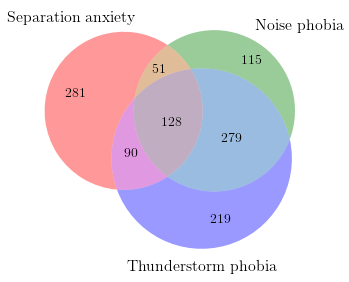

Chi-squared Test of Independence for Thunderstorm phobia, Noise phobia, and Separation anxiety:
chi2 = 285.272663, p = 1.53E-61, dof = 3


,Thunderstorm phobia,Noise phobia,Separation anxiety
Thunderstorm phobia,1.000000,0.568962,0.211230
Noise phobia,0.568962,1.000000,0.230353
Separation anxiety,0.211230,0.230353,1.000000


In [146]:
# Create a contingency table.
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
contingency = pd.crosstab(df[labels[2]], [df[labels[0]], df[labels[1]]])

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[2]: contingency[0][0][1],
     labels[1]: contingency[1][0][0],
     'Separation-Noise': contingency[1][0][1],
     labels[0]: contingency[0][1][0],
     'Separation-Thunderstorm': contingency[0][1][1],
     'Noise-Thunderstorm': contingency[1][1][0],     
     'All': contingency[1][1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
v = venn3(cross_sums, set_labels=[cross_sums.index.values[i] for i in [0, 1, 3]])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x+0.25, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_1')
plt.show()

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s, %s, and %s:' %(labels[0], labels[1], labels[2]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

## <center>Separation Anxiety, Destructive Behavior, and House Soiling</center>

In [147]:
### Desctructive and separation anxiety:

Separation anxiety,0,1
Destruction,,
0,3220,405
1,344,145


odds ratio = 3.351278


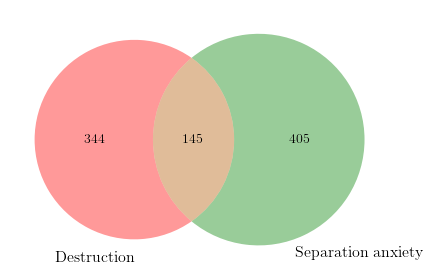

Chi-square Test of Independence:
chi2 = 127.052083, p = 1.81E-29, dof = 1


,Destruction,Separation anxiety
Destruction,1.000000,0.175735
Separation anxiety,0.175735,1.000000


In [148]:
# Create the necessary dataframe.
fields = 'q02_main_9, q04_9'
labels = ['Destruction', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)
displayOddsRatio(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_5')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

In [149]:
### House soiling during owner absence and separation anxiety:

Separation anxiety,0,1
House soiling (owner absence),,
0,3234,429
1,330,121


odds ratio = 2.764103


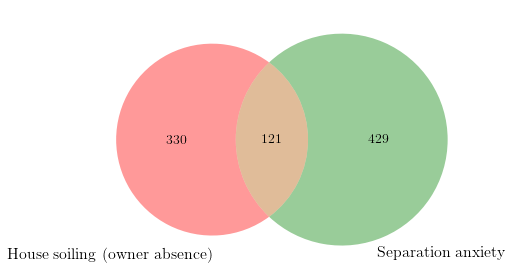

Chi-square Test of Independence:
chi2 = 79.239289, p = 5.50E-19, dof = 1


,House soiling (owner absence),Separation anxiety
House soiling (owner absence),1.000000,0.138784
Separation anxiety,0.138784,1.000000


In [150]:
# Create the necessary dataframe.
fields = 'q06_situation_2, q04_9'
labels = ['House soiling (owner absence)', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)
displayOddsRatio(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_5')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

## <center>Fear/Anxiety and House Soiling</center>

## <center>Fear/Anxiety and Aggression</center>

In [151]:
### Overall aggression and fearful/anxious behavior:

Fear/Anxiety,0,1
Aggression,,
0,1765,1110
1,535,704


odds ratio = 2.092380


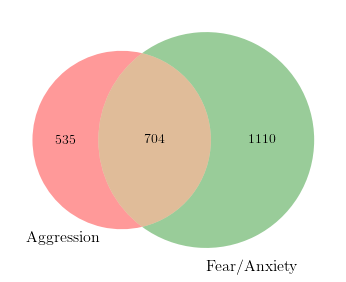

Chi-square Test of Independence:
chi2 = 116.490685, p = 3.71E-27, dof = 1


,Aggression,Fear/Anxiety
Aggression,1.000000,0.168273
Fear/Anxiety,0.168273,1.000000


In [152]:
# Create the necessary dataframe.
fields = 'q02_main_1, q02_main_2'
labels = ['Aggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)
displayOddsRatio(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_2')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

In [153]:
### Owner directed aggression and fearful/anxious behavior:

Fear/Anxiety,0,1
Owner directed aggression,,
0,2198,1620
1,102,194


odds ratio = 2.580562


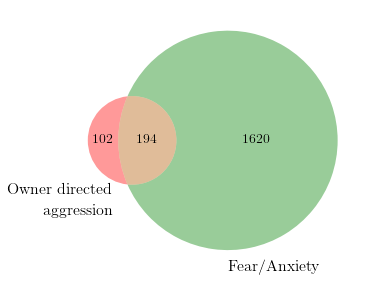

Chi-square Test of Independence:
chi2 = 59.514770, p = 1.21E-14, dof = 1


,Owner directed aggression,Fear/Anxiety
Owner directed\naggression,1.000000,0.120276
Fear/Anxiety,0.120276,1.000000


In [154]:
# Create the necessary dataframe.
fields = 'q03_main_1, q02_main_2'
labels = ['Owner directed\naggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)
displayOddsRatio(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_3')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

In [155]:
### Owner directed aggression and separation anxiety:

Separation anxiety,0,1
Owner directed aggression,,
0,3344,474
1,220,76


odds ratio = 2.437131


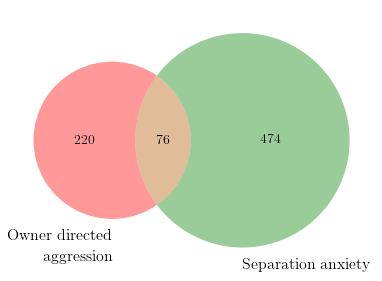

Chi-square Test of Independence:
chi2 = 41.709109, p = 1.06E-10, dof = 1


,Owner directed aggression,Separation anxiety
Owner directed\naggression,1.000000,0.100689
Separation anxiety,0.100689,1.000000


In [156]:
# Create the necessary dataframe.
fields = 'q03_main_1, q04_9'
labels = ['Owner directed\naggression', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)
displayOddsRatio(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_4')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

## <center>Fear/Anxiety and Compulsive Behavior</center>

In [157]:
### (Figure ?)

Compulsion,0,1
Fear/Anxiety,,
0,2020,280
1,1455,359


odds ratio = 1.780020


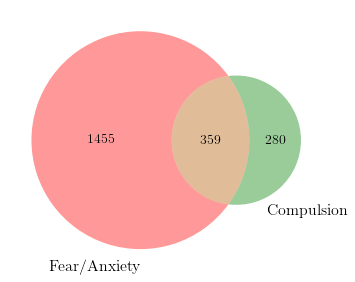

Chi-square Test of Independence:
chi2 = 44.843203, p = 2.13E-11, dof = 1


,Fear/Anxiety,Compulsion
Fear/Anxiety,1.000000,0.104404
Compulsion,0.104404,1.000000


In [158]:
# Create the necessary dataframe.
fields = 'q02_main_2, q02_main_3'
labels = ['Fear/Anxiety', 'Compulsion']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)
displayOddsRatio(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_5')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
display(df.corr())

## <center>Coprophagia and Age</center>

In [159]:
fields = ', '.join(FR.fields[FR.categories[7]])
fields += ', q01_age_months'
labels = list(FR.labels[FR.categories[7]].values())
labels.append('age')
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)


# Ranges: 0=0-3m, 1=3-6m, 2=6m-1y, 3=1-3y, 4=3y+, 5=evident at acquisition
df['age<1y'] = np.where(df['age'] < 12, 1, 0)
df['age>=1y'] = np.where(df['age'] >= 12, 1, 0)
df = df.fillna(0)
df['NR'] = np.where(df['age'] == 0, 1, 0)
df = df.drop(columns=['age'])

df_copro = df[(df[labels[0]] == 1) | (df[labels[1]] == 1) | (df[labels[2]] == 1)].drop(
    columns=[labels[0], labels[1], labels[2]])

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / 1) * 100)
    return df.round(2)

df = df_copro.sum()
display(df_copro.sum())

print("These results are no good!")

# Manually I got 605 with age < 12 months and 112 with age > 12 months.

age<1y      64
age>=1y     56
NR         597
dtype: int64

These results are no good!


## <center>Overactivity/Hyperactivity and Age</center>

In [160]:
# Done by hand
# SELECT COUNT(*) FROM dogs JOIN users USING (record_id) WHERE (question_reason_for_part_3 = 0 OR (question_reason_for_part_3 = 1 AND q01_main != 1)) AND (q01_age_months > 12 and (q02_main_13));
# age < 12 months = 409, age > 12 months = 96 --> total = 505

## <center>Bite Severity</center>

In [161]:
### Breakdown of bite severity:

In [162]:
fields = 'q03_severity'
labels = ['severity']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
#replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "count"}, inplace=True)
df.columns.name = labels[0]
display(df)

severity,count
3.0,182
2.0,119
4.0,41
1.0,20
5.0,13


In [163]:
### Bite severity by behavior problem:

In [164]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)
fields.append('q03_severity')
labels.append('severity')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)


rngs = []
rngs.append(df[(df['severity'] == 1)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 2)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 3)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 4)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 5)].drop(columns=['severity']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    #df = df.sum().apply(lambda x: (x / 1))
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))
prevs.append(get_group_prevalence(rngs[2]))
prevs.append(get_group_prevalence(rngs[3]))
prevs.append(get_group_prevalence(rngs[4]))

df = pd.DataFrame(index=prevs[0].index, data={'level 1': prevs[0], 'level 2': prevs[1], 'level 3': prevs[2],
                                                   'level 4': prevs[3], 'level 5': prevs[4]})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_6') # Exporting will overwrite custom formatting

Behavior problem,level 1,level 2,level 3,level 4,level 5
Aggression,100.0,100.00,100.00,100.00,100.00
Fear/Anxiety,55.0,57.14,64.29,46.34,84.62
Compulsion,25.0,18.49,25.27,12.20,38.46
House Soiling,35.0,26.05,20.33,21.95,23.08
Excessive Barking,40.0,26.89,30.22,26.83,38.46
Jumping,30.0,36.97,34.62,39.02,7.69
Mounting/Humping,5.0,19.33,15.93,12.20,0.00
Coprophagia,15.0,20.17,22.53,24.39,7.69
Destructive Behavior,15.0,12.61,15.93,19.51,15.38
Rolling in Repulsive Material,25.0,22.69,15.38,9.76,23.08


In [165]:
### Bite severity and fear/anxiety:

In [166]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[FR.categories[1]])
labels = list(FR.labels[FR.categories[1]].values())
fields += ', q03_severity'
labels.append('severity')
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

rngs = []
rngs.append(df[(df['severity'] == 1)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 2)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 3)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 4)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 5)].drop(columns=['severity']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))
prevs.append(get_group_prevalence(rngs[2]))
prevs.append(get_group_prevalence(rngs[3]))
prevs.append(get_group_prevalence(rngs[4]))

df = pd.DataFrame(index=prevs[0].index, data={'level 1': prevs[0], 'level 2': prevs[1], 'level 3': prevs[2],
                                                   'level 4': prevs[3], 'level 5': prevs[4]})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_6') # Exporting will overwrite custom formatting

Behavior problem,level 1,level 2,level 3,level 4,level 5
Thunderstorm phobia,5.0,21.85,24.18,14.63,38.46
Noise phobia,10.0,23.53,29.67,14.63,30.77
Crowd phobia,20.0,31.09,29.12,29.27,46.15
Phobia of other dogs,20.0,14.29,18.68,9.76,30.77
PTSD,10.0,4.20,9.34,14.63,23.08
Generalized anxiety,10.0,13.45,20.88,19.51,53.85
Situational anxiety,25.0,27.73,32.97,31.71,53.85
Veterinarian phobia,25.0,24.37,32.97,21.95,30.77
Separation anxiety,15.0,19.33,24.18,12.20,53.85
Travel anxiety,20.0,12.61,17.58,7.32,38.46


In [167]:
### Bite severity and gender and neutered status

In [168]:
#Construct the dataframe.
fields = ['q03_severity']
labels = ['severity']
fields.extend(('dog_sex', 'dog_spayed'))
labels.extend(('Gender', 'Neutered'))
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

df['level 1'] = np.where(df['severity'] == 1, 1, 0)
df['level 2'] = np.where(df['severity'] == 2, 1, 0)
df['level 3'] = np.where(df['severity'] == 3, 1, 0)
df['level 4'] = np.where(df['severity'] == 4, 1, 0)
df['level 5'] = np.where(df['severity'] == 5, 1, 0)
df = df.drop(columns=['severity'])


df_intact_male = df[(df['Gender'] == 1) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_male = df[(df['Gender'] == 1) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])
df_intact_female = df[(df['Gender'] == 2) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_female = df[(df['Gender'] == 2) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])

def get_group_prevalence(df):
    #df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    df = df.sum().apply(lambda x: (x / 1))
    return df.round(2)

intact_male_p = get_group_prevalence(df_intact_male)
neutered_male_p = get_group_prevalence(df_neutered_male)
intact_female_p = get_group_prevalence(df_intact_female)
neutered_female_p = get_group_prevalence(df_neutered_female)

df = pd.DataFrame(index=intact_male_p.index, data={'Intact males': intact_male_p,
                                                   'Castrated males': neutered_male_p,
                                                   'Intact females': intact_female_p,
                                                   'Spayed females': neutered_female_p})
df.columns.name = 'Behavior problem'
display(df)

# by hand: 3.504043127	52.83018868	3.234501348	40.43126685	100

Behavior problem,Intact males,Castrated males,Intact females,Spayed females
level 1,1.0,10.0,1.0,8.0
level 2,3.0,64.0,5.0,45.0
level 3,5.0,97.0,4.0,74.0
level 4,4.0,18.0,1.0,18.0
level 5,0.0,7.0,1.0,5.0


## <center>Appendix</center>

In [169]:
### Behavior problem category heat map (Appendix 2)

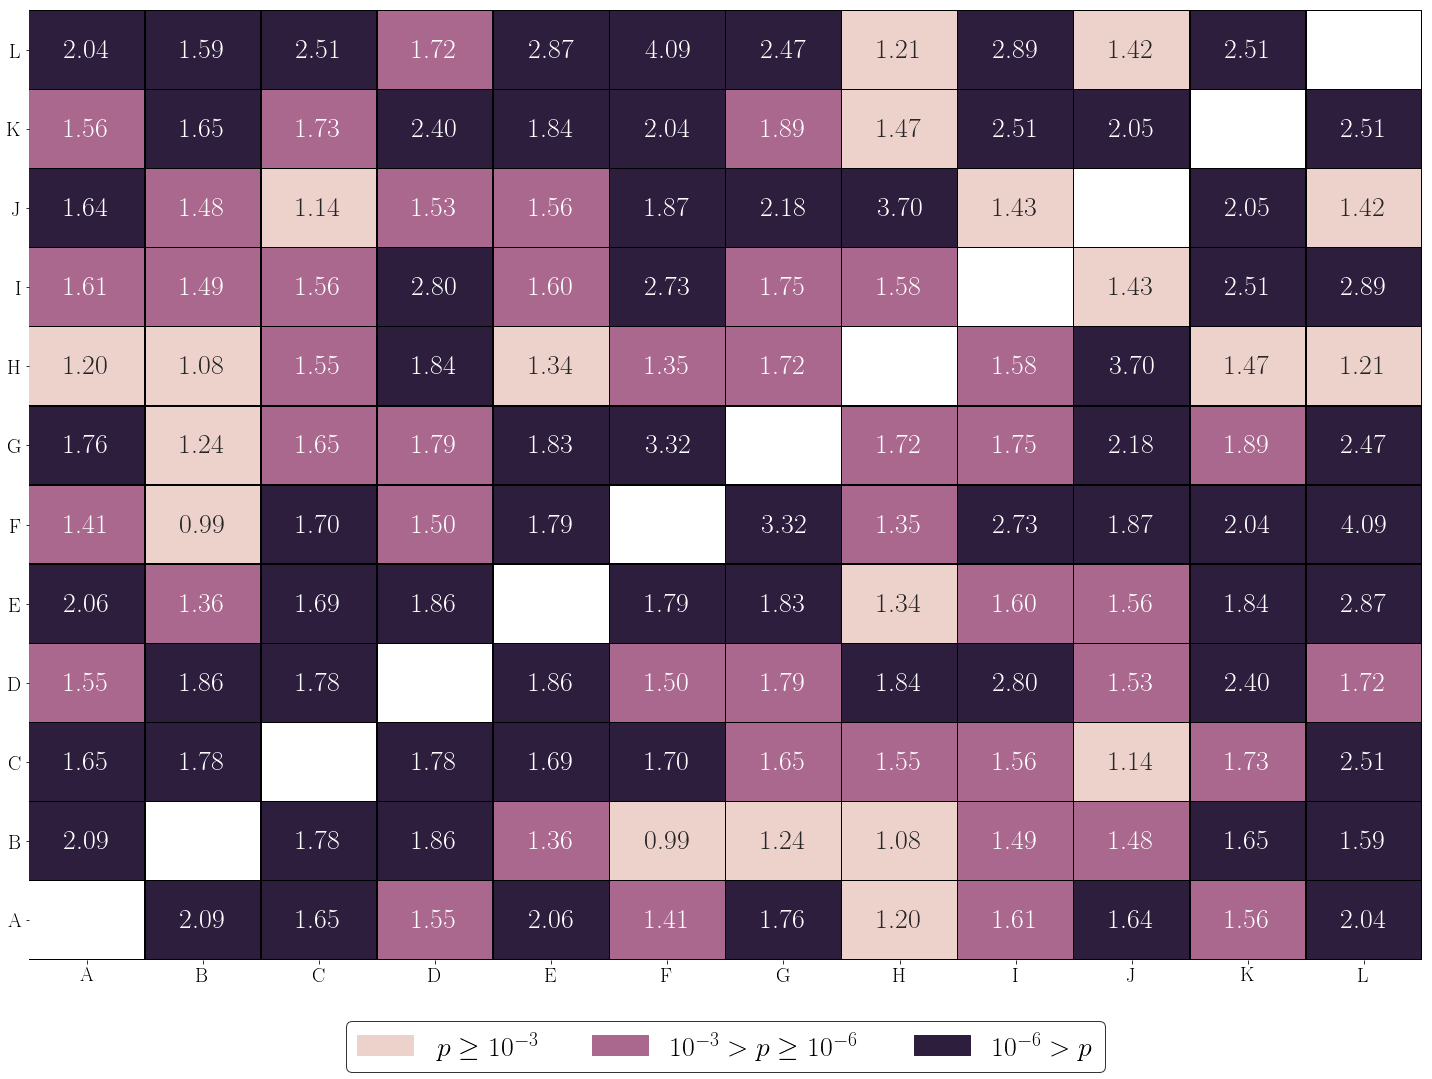

In [170]:
if CATEGORY_MATRIX.empty:
    CATEGORY_MATRIX = createCategoryMatrix()
    
# Create a new dataframe with categories:
df = CATEGORY_MATRIX.applymap(lambda row: get_significance_category(row))
df_or = createOddsRatioMatrix()

# Heatmap
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.cubehelix_palette(n_colors=3)
ax = sns.heatmap(data=df, ax=ax, cmap=ListedColormap(cmap), linewidths=0.5, linecolor='black',
                 cbar=False, mask=df.isnull(), annot=df_or, annot_kws={"size": 28}, fmt='.2f')
plt.xticks(rotation=0, fontsize=20)
plt.yticks(rotation=0, fontsize=20)
ax.invert_yaxis()
import matplotlib.patches as mpatches
patch_1 = mpatches.Patch(color=cmap[0], label='$p\geq10^{-3}$')
patch_2 = mpatches.Patch(color=cmap[1], label='$10^{-3}>p\geq10^{-6}$')
patch_3 = mpatches.Patch(color=cmap[2], label='$10^{-6}>p$')
legend = plt.legend(handles=[patch_1, patch_2, patch_3], bbox_to_anchor=(0.5, -0.05), loc='upper center',
                    fontsize=28, ncol=3)
legend.get_frame().set_edgecolor('black')
exportFigure(fig, 'figure_6')
plt.show()

In [171]:
### Heat map axes abbrevation reference chart (Appendix 3)

In [172]:
# Construct lists.
cat_dict = {}
for cat, subdict in FR.labels.items():
    for key, value in  subdict.items():
        cat_dict[key[0]] = cat
        break

s = pd.Series(cat_dict)
df = pd.DataFrame(index=s.index, data={'Category':s.values})
df.columns.name = 'Index'
display(df)
exportTable(df, 'table_category_reference')

Index,Category
A,Aggression
B,Fear/Anxiety
C,Compulsion
D,House Soiling
E,Excessive Barking
F,Jumping
G,Mounting/Humping
H,Coprophagia
I,Destructive Behavior
J,Rolling in Repulsive Material
